# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

In [6]:
data_size = int(1e3)

In [7]:
# Data points
m1  = np.random.uniform(0, 1, data_size)
m2  = np.random.uniform(0, 1, data_size)
r   = np.random.uniform(1, 4, data_size)
X_array = np.stack((m1, m2, r), axis=0)
G   = 1.184
y_array = m1*m2*G/r**2

# One of many symbolic solutions:
target_program_str = ["div", "mul", "mul", "m1", "m2", "G", "n2", "r",]
print(len(target_program_str))


8


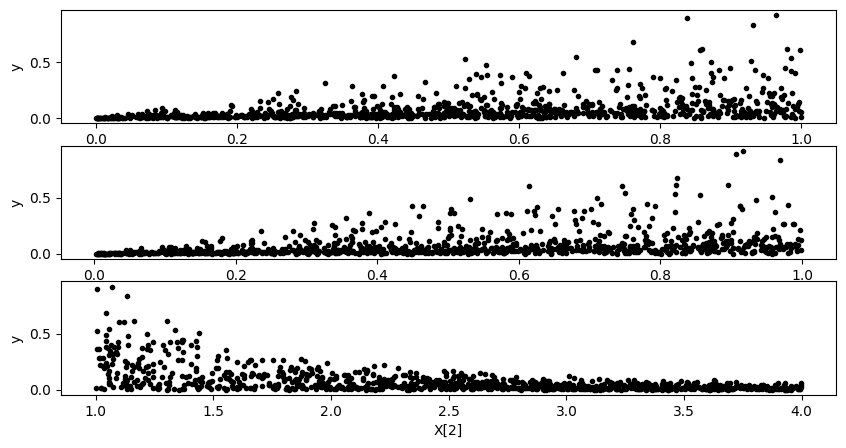

In [8]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [9]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array( 1.   )).to(DEVICE)
G      = torch.tensor(np.array( G    )).to(DEVICE)

## Run config

### Library config

In [10]:
# [length, mass, time]
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"m1" : 0         , "m2" : 1         , "r" : 2         , },
                "input_var_units"      : {"m1" : [0, 1, 0] , "m2" : [0, 1, 0] , "r" : [1, 0, 0] , },
                "input_var_complexity" : {"m1" : 1.        , "m2" : 1.        , "r" : 1.        , },
                # constants
                "constants"            : {"1" : const1    , "G" : G           ,},
                "constants_units"      : {"1" : [0, 0, 0] , "G" : [3, -1, -2] ,},
                "constants_complexity" : {"1" : 1.        , "G" : 1.          ,},
                ## free constants
                #"free_constants"            : {"m"              , "g"              ,},
                #"free_constants_init_val"   : {"m" : 1.         , "g" : 1.         ,},
                #"free_constants_units"      : {"m" : [0, 0, 1]  , "g" : [1, -2, 0] ,},
                #"free_constants_complexity" : {"m" : 1.         , "g" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [1, 1, -2],
                  "superparent_name"  : "F",
                }


### Learning config

In [11]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, 
                 "zero_out_unphysical" : True, # PHYSICALITY
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [12]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [13]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Free constant optimizer config

In [14]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [15]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                #("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [16]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [17]:
save_path_training_curves = 'classical_gravity_curves.png'
save_path_log             = 'classical_gravity.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 10,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [18]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

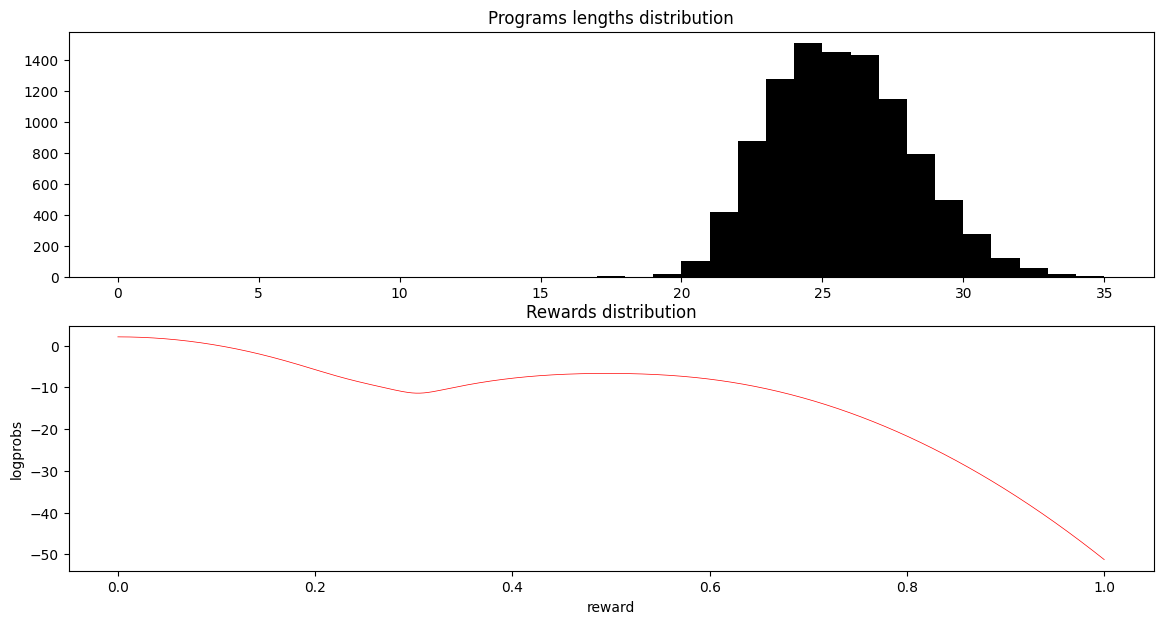

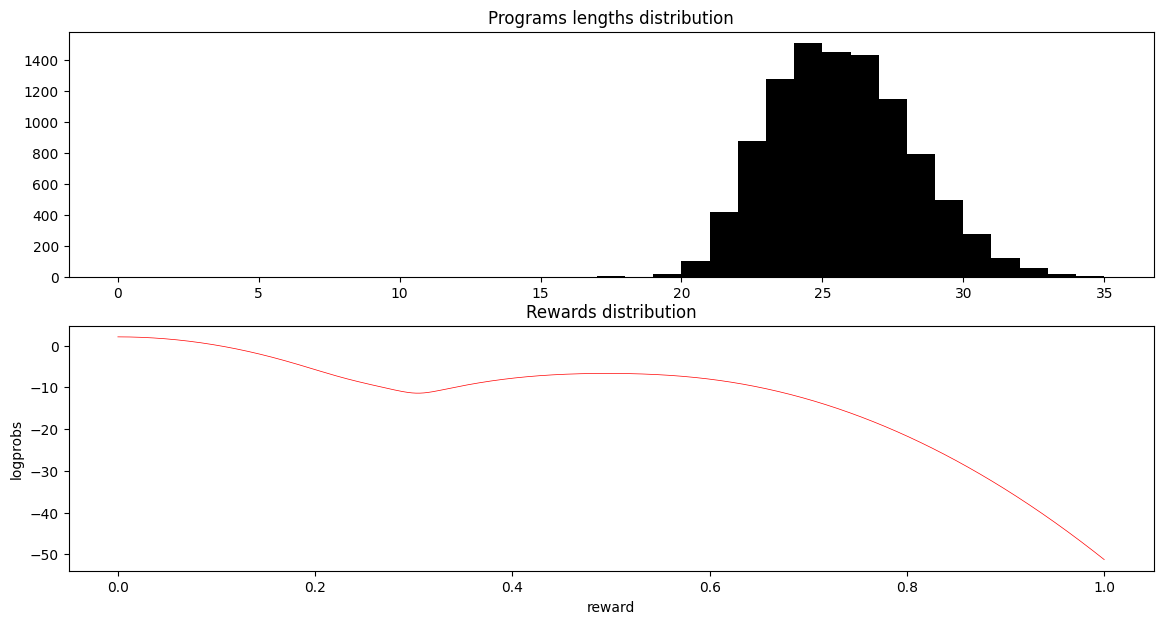

In [19]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


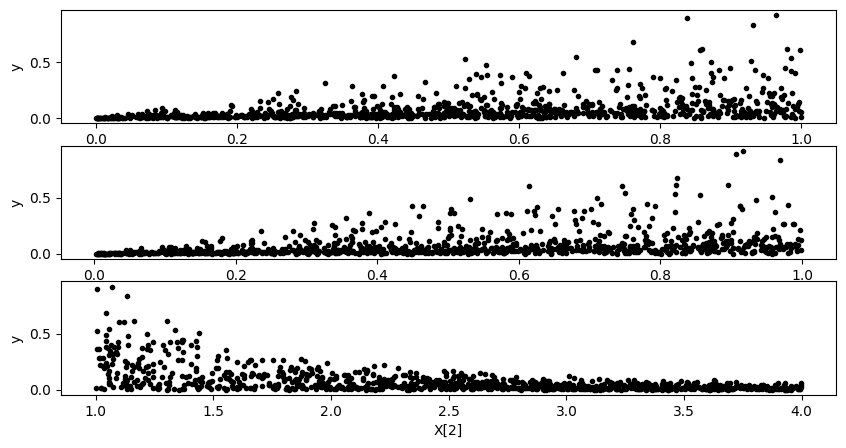

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'G': 12, 'm1': 13, 'm2': 14, 'r': 15}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 G m1 m2 r F dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
-------------------------- Dataset -------------------------
X        : torch.Size([3, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ...
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '

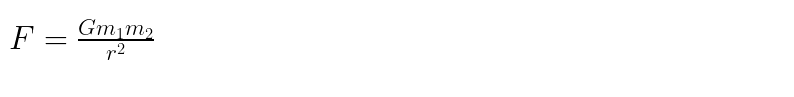

Simplified expression:


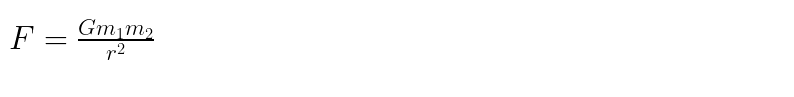

Ideal reward : 1.0


In [20]:
target_program = benchmark.sanity_check(X, y, run_config, 
                                        target_program_str = target_program_str,
                                        expected_ideal_reward = 1.,
                                       )

## Run

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 8.80 s

Overall best  at R=0.000000
-> Raw expression : 
                      G                      
─────────────────────────────────────────────
⎛                     0.5                   ⎞
⎜                    r                      ⎟
⎜───────────────────────────────────────────⎟
⎜    ⎛             2    ⎞                   ⎟
⎜    ⎜⎛     1     ⎞     ⎟ ⎛          cos(1)⎞⎟
⎜G + ⎜⎜───────────⎟  + 1⎟⋅⎝log(1) + ℯ      ⎠⎟
⎜    ⎜⎜        0.5⎟     ⎟                   ⎟
⎜    ⎜⎜⎛   0.5⎞   ⎟     ⎟                   ⎟
⎜    ⎜⎜⎜⎛1⎞   ⎟   ⎟     ⎟                   ⎟
⎜    ⎜⎜⎜⎜─⎟   ⎟   ⎟     ⎟                   ⎟
⎝    ⎝⎝⎝⎝G⎠   ⎠   ⎠     ⎠                   ⎠

Best of epoch at R=0.000000
-> Raw expression : 
                      G                      
─────────────────────────────────────────────
⎛                     0.5                   ⎞
⎜                    r                      ⎟
⎜───────────────────────────────────────────⎟
⎜    ⎛             2 

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00010 ===========
-> Time 18.29 s

Overall best  at R=0.923973
-> Raw expression : 
       1   
m₂⋅1⋅──────
     ⎛ r  ⎞
     ⎜────⎟
     ⎜   G⎟
     ⎜m₁⋅─⎟
     ⎝   r⎠

Best of epoch at R=0.923973
-> Raw expression : 
       1   
m₂⋅1⋅──────
     ⎛ r  ⎞
     ⎜────⎟
     ⎜   G⎟
     ⎜m₁⋅─⎟
     ⎝   r⎠


=========== Epoch 00011 ===========
-> Time 10.10 s

Overall best  at R=0.923973
-> Raw expression : 
       1   
m₂⋅1⋅──────
     ⎛ r  ⎞
     ⎜────⎟
     ⎜   G⎟
     ⎜m₁⋅─⎟
     ⎝   r⎠

Best of epoch at R=0.541170
-> Raw expression : 
                            2
  ⎛        ⎛       1      ⎞⎞ 
  ⎜        ⎜ ─────────────⎟⎟ 
  ⎜        ⎜ log(1⋅cos(1))⎟⎟ 
  ⎜m₁⋅r⋅cos⎝ℯ             ⎠⎟ 
G⋅⎜────────────────────────⎟ 
  ⎜         ⎛ r ⎞          ⎟ 
  ⎜         ⎜───⎟          ⎟ 
  ⎜         ⎜⎛1⎞⎟          ⎟ 
  ⎜         ⎜⎜─⎟⎟          ⎟ 
  ⎝         ⎝⎝r⎠⎠          ⎠ 


=========== Epoch 00012 ===========
-> Time 8.95 s

Overall best  at R=0.999954
-> Raw expression : 
         

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00020 ===========
-> Time 18.10 s

Overall best  at R=1.000000
-> Raw expression : 
    m₁    
──────────
⎛  G⋅r   ⎞
⎜────────⎟
⎜      1 ⎟
⎜G⋅m₂⋅───⎟
⎜     ⎛r⎞⎟
⎜     ⎜─⎟⎟
⎝     ⎝G⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
       m₁       
────────────────
        r       
r⋅──────────────
  ⎛     m₂     ⎞
  ⎜────────────⎟
  ⎜      1     ⎟
  ⎜r⋅──────────⎟
  ⎜  ⎛   r    ⎞⎟
  ⎜  ⎜────────⎟⎟
  ⎜  ⎜       2⎟⎟
  ⎜  ⎜  ⎛  1⎞ ⎟⎟
  ⎜  ⎜G⋅⎜1⋅─⎟ ⎟⎟
  ⎝  ⎝  ⎝  G⎠ ⎠⎠


=========== Epoch 00021 ===========
-> Time 9.77 s

Overall best  at R=1.000000
-> Raw expression : 
    m₁    
──────────
⎛  G⋅r   ⎞
⎜────────⎟
⎜      1 ⎟
⎜G⋅m₂⋅───⎟
⎜     ⎛r⎞⎟
⎜     ⎜─⎟⎟
⎝     ⎝G⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
G⋅G⋅m₁⋅m₂
─────────
 ⎛  r  ⎞ 
 ⎜─────⎟ 
 ⎜   1 ⎟ 
 ⎜1⋅───⎟ 
 ⎝  G⋅r⎠ 


=========== Epoch 00022 ===========
-> Time 9.23 s

Overall best  at R=1.000000
-> Raw expression : 
    m₁    
──────────
⎛  G⋅r   ⎞
⎜────────⎟
⎜      1 ⎟
⎜G⋅m₂⋅───⎟
⎜     ⎛r⎞⎟
⎜     ⎜─⎟

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00030 ===========
-> Time 16.48 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
 ⎛ r ⎞ 
 ⎜───⎟ 
 ⎜⎛1⎞⎟ 
 ⎜⎜─⎟⎟ 
 ⎝⎝r⎠⎠ 


=========== Epoch 00031 ===========
-> Time 9.54 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
 G⋅G⋅m₁ 
────────
      1 
G⋅r⋅r⋅──
      m₂


=========== Epoch 00032 ===========
-> Time 9.07 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
    1       1
m₁⋅───⋅1⋅m₂⋅─
   ⎛r⎞      r
   ⎜─⎟       
   ⎝G⎠       


=========== Epoch 00033 ===========
-> Time 8.82 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00040 ===========
-> Time 16.34 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
     1       1     
m₁⋅1⋅─⋅r⋅──────────
     r   ⎛   r    ⎞
         ⎜────────⎟
         ⎜⎛  G   ⎞⎟
         ⎜⎜──────⎟⎟
         ⎜⎜    1 ⎟⎟
         ⎜⎜1⋅r⋅──⎟⎟
         ⎝⎝    m₂⎠⎠


=========== Epoch 00041 ===========
-> Time 8.83 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
 m₁⋅m₂ 
───────
⎛ m₂⋅r⎞
⎜─────⎟
⎜⎛ m₂⎞⎟
⎜⎜───⎟⎟
⎜⎜⎛r⎞⎟⎟
⎜⎜⎜─⎟⎟⎟
⎝⎝⎝G⎠⎠⎠


=========== Epoch 00042 ===========
-> Time 8.47 s

Overall best  at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
⎛  r  ⎞
⎜─────⎟
⎜⎛ 1 ⎞⎟
⎜⎜───⎟⎟
⎜⎜  r⎟⎟
⎜⎜1⋅─⎟⎟
⎝⎝  1⎠⎠

Best of epoch at R=1.000000
-> Raw expression : 
G⋅m₁⋅m₂
───────
 ⎛ r ⎞ 
 ⎜───⎟ 
 ⎜⎛1⎞⎟ 
 ⎜⎜─⎟⎟ 
 ⎝⎝r⎠⎠ 


=========== Epoc

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/PhySO/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


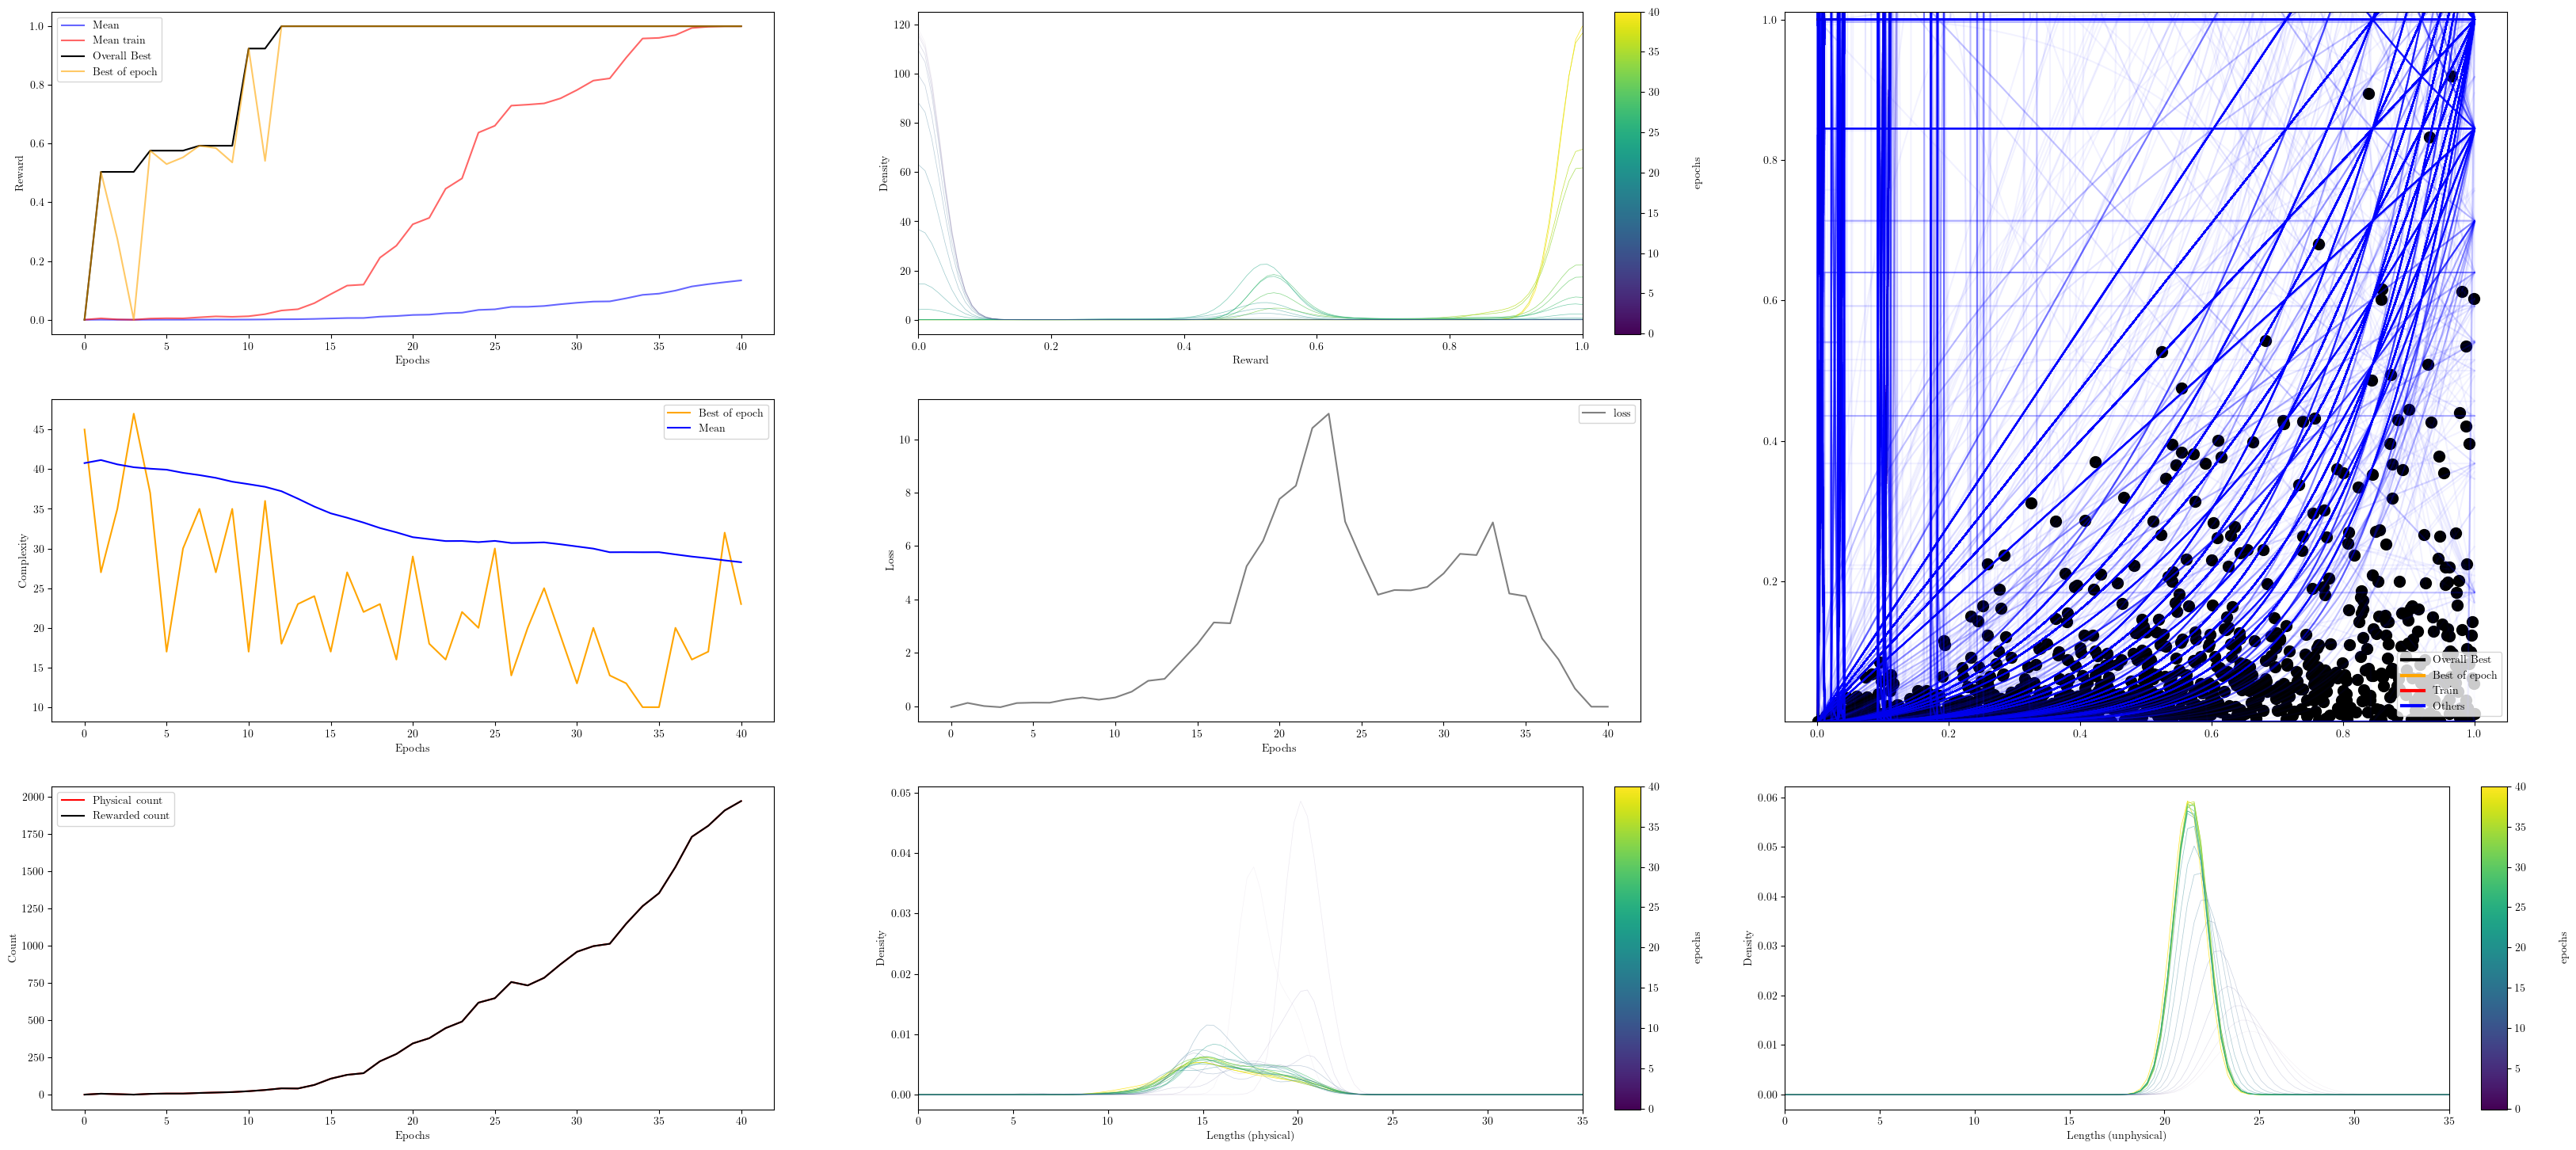

In [21]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 1., 
                                stop_after_n_epochs = 30)

## Results

### Run plot

In [22]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


### Pareto Front

In [31]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

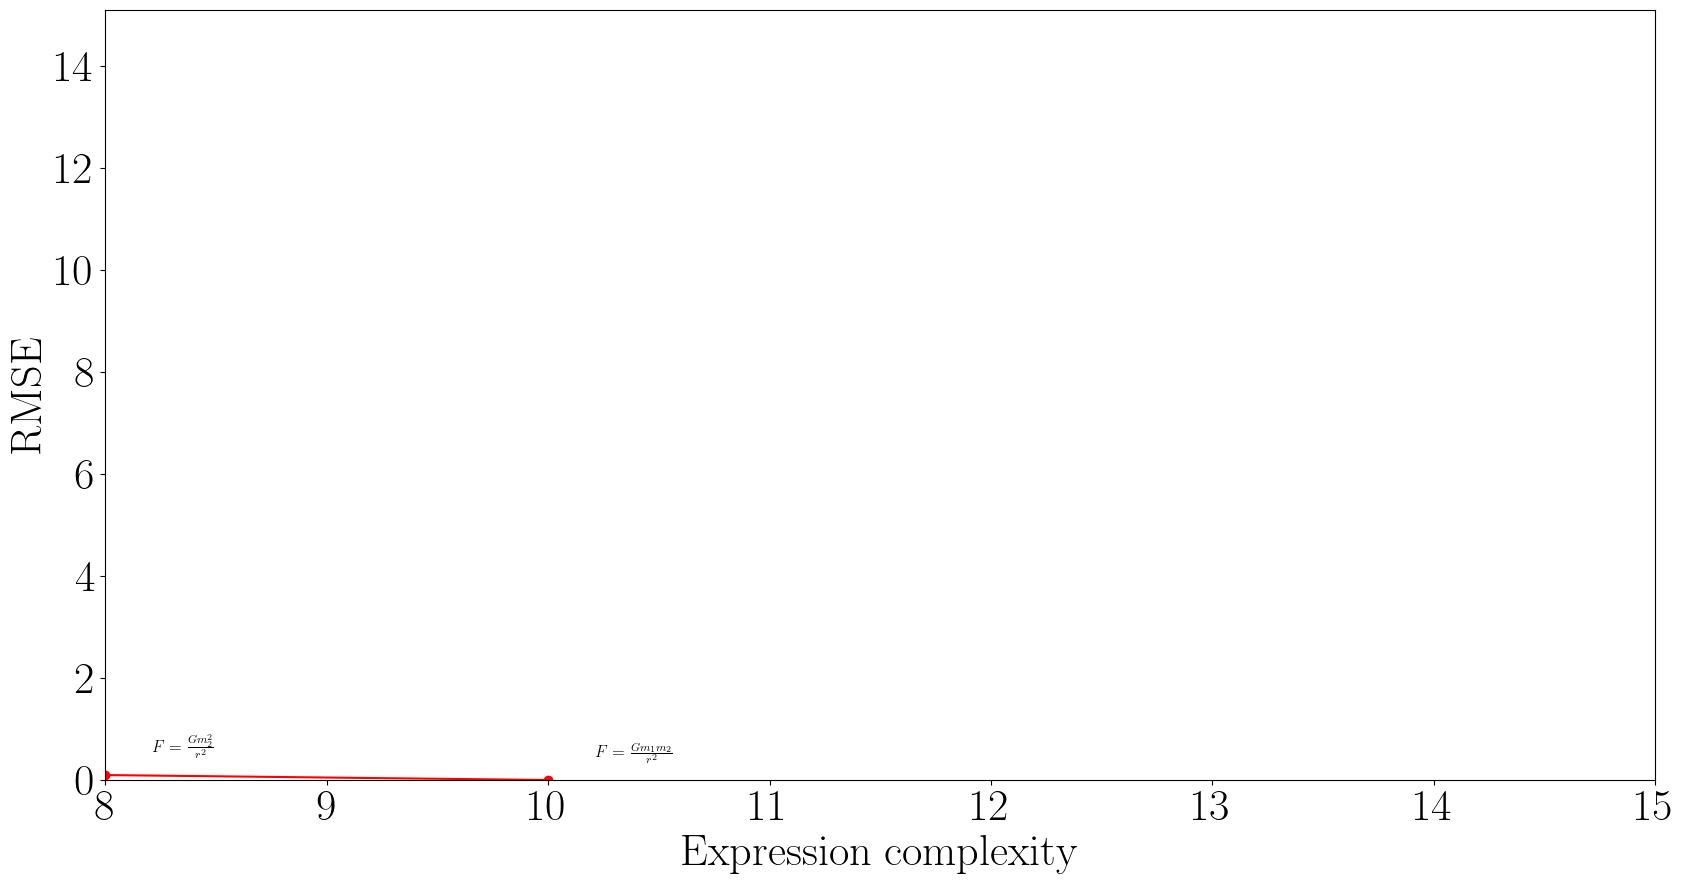

In [32]:
plot_pareto_front(run_logger)


In [26]:
run_logger.get_pareto_front()

(array([ 8, 10]),
 array([[mul G n2 div m2 r], [mul mul m2 m1 div G mul r r]], dtype=object),
 array([0.53026242, 1.        ]),
 array([0.09705898, 0.        ]))

In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])